In [31]:
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import pandas as pd
from teneto import TemporalNetwork
import json
from collections import defaultdict
import warnings
from os import listdir
from tqdm import tqdm
import math
import bz2
from os.path import isfile, join
from scipy import sparse
import graphlets
import PyBliss
import pandas as pd
from scipy.ndimage.filters import gaussian_filter1d
import os
import seaborn as sns

import pickle
import networkx as nx

from multiprocessing import Queue, Process
warnings.filterwarnings("ignore")

In [339]:
n_cores = 25
PATH = "/mnt/erebor1/Daten/ABI2/crawls/dreddit/"
min_posts = 10

files =  [join(PATH + "comments/", f) for f in listdir(PATH + "comments/") 
          if isfile(join(PATH + "comments/", f))]

n_files = 25

<h3> Submission Comment Forest </h3>

In [216]:
def is_relevant_title(title):
    return any(keyword in title.lower() for keyword in ["ukraine", "putin", "kyiv", "russia"]) 

In [217]:
def create_comment_forest(file_paths):
    G = nx.DiGraph()
    
    for file_path in tqdm(file_paths):
        with bz2.open(file_path, "rt") as file:
            for line in file:
                comment = json.loads(line)
                comment_id = comment.get("name")
                parent_id = comment.get("parent_id")
                submission_id = comment.get("link_id")
                subreddit_id = comment.get("subreddit_id")
                subreddit_name = comment.get("subreddit")
                user_id = comment.get("author_fullname")
                link_title = comment.get("link_title")
                created_at = comment.get("created_utc")
                
                if not is_relevant_title(link_title):
                    continue
                    
                if parent_id == submission_id:  # top level comment
                    G.add_node(parent_id, subreddit_id=subreddit_id, subreddit_name=subreddit_name, link_title=link_title)
                    G.add_node(comment_id, user_id=user_id)
                    G.add_edge(parent_id, comment_id, created_at=created_at)
                elif G.has_node(parent_id):  # only insert comment if we know the start of a comment forest
                    G.add_node(submission_id, user_id=user_id)
                    G.add_edge(parent_id, comment_id, created_at=created_at)
                    
    return G

In [218]:
files =  [join(PATH + "comments/", f) for f in listdir(PATH + "comments/") 
          if isfile(join(PATH + "comments/", f))]

comment_forest = create_comment_forest(files[:1])

100%|██████████| 1/1 [00:08<00:00,  8.91s/it]


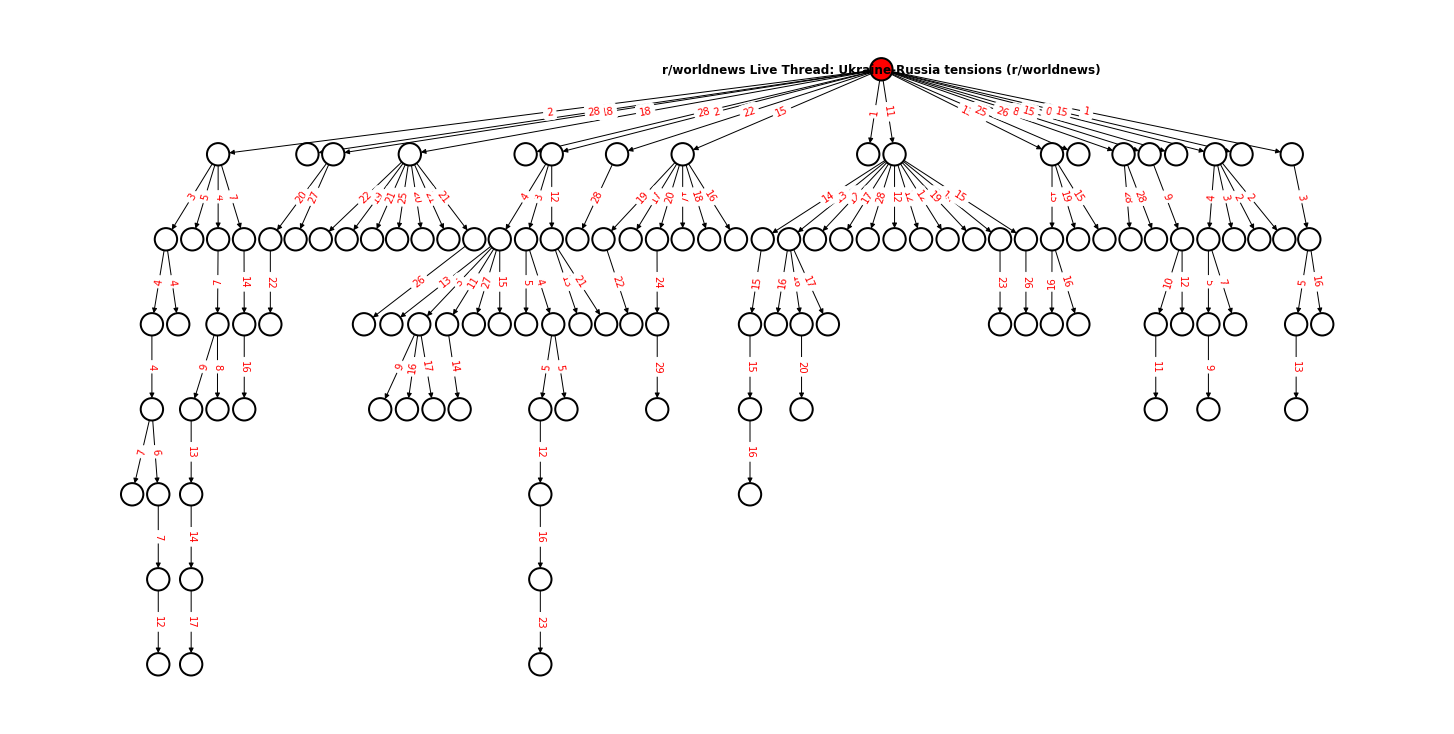

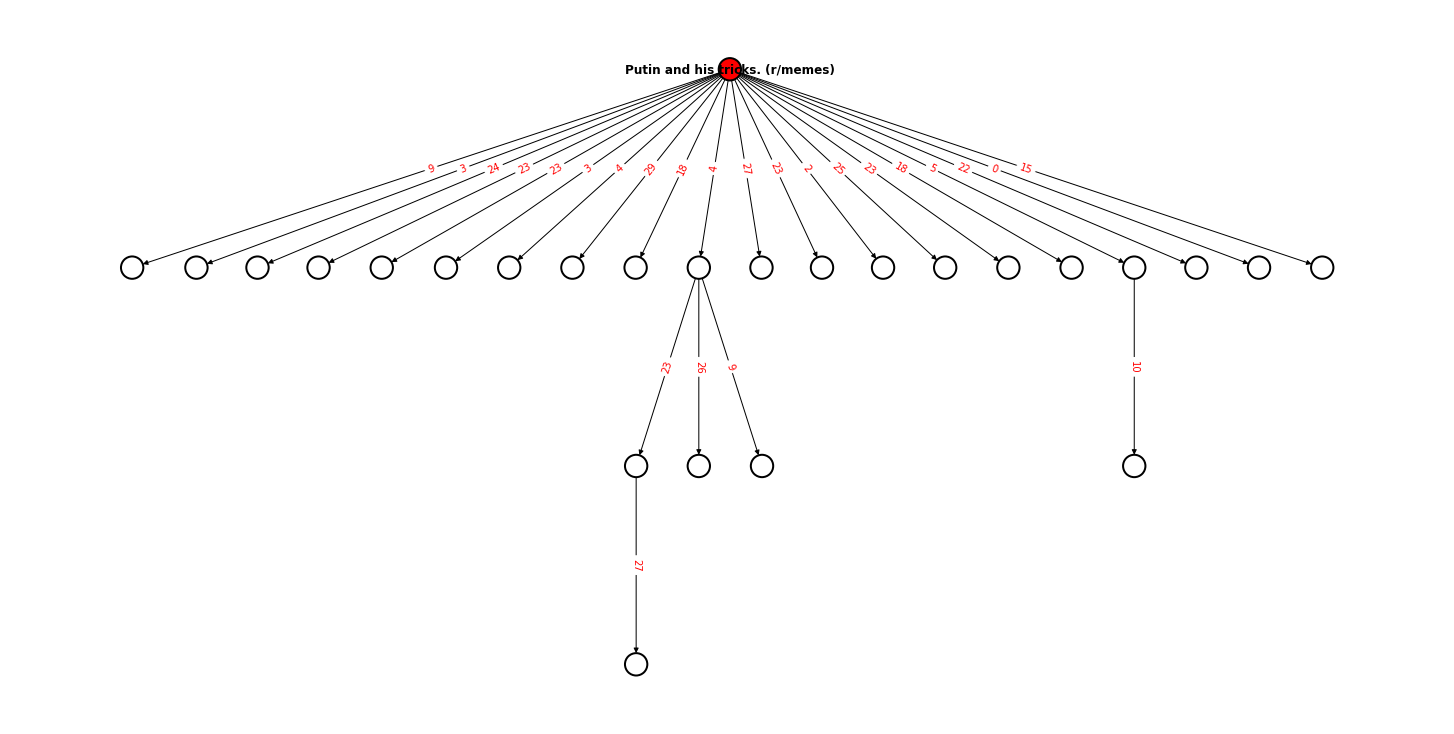

In [220]:
cnt = 3
for submission_graph in nx.weakly_connected_components(comment_forest):
    if len(submission_graph) > 10:
        H = comment_forest.subgraph(submission_graph)
        
        # node colors
        colormap = ["red" if "t3" in node else "white" for node in H.nodes()]
        
        # node labels
        node_labels = {node: "{} (r/{})".format(H.nodes[node]["link_title"], H.nodes[node]["subreddit_name"]) if "t3" in node else "" for node in H.nodes()}
        
        # edge labels: minutes since post creation (or right now as a work around: since first comment)
        edge_labels = {(u, v):  H.get_edge_data(u, v,).get("created_at") for u, v in H.edges()}
        start = min(edge_labels.values())
        step = 60
        edge_labels = {k: math.ceil((v-start) / step) for k,v in edge_labels.items()}
        
        pos=graphviz_layout(H, prog='dot')
        
        plt.figure(figsize=(20, 10))
        nx.draw(H,
                pos,
            #connectionstyle="arc3,rad=0.15",
            node_color=colormap, 
            node_size=500, 
            with_labels=True, 
            linewidths=2,
            #width=alphas, 
            edgecolors="black",
            font_weight="bold",
            labels=node_labels)
           #edge_color=colors)
        
        nx.draw_networkx_edge_labels(
            H, pos,
            edge_labels=edge_labels,
            font_color='red'
        )
        # plt.savefig("comment_tree_example.pdf")
        plt.show()
        cnt -= 1
        if cnt == 0:
            break

<h3> Beschreibe den Kommentarbaum von Submissions als Graphlet-Vektor </h3>

- Geht der Kommentarbaum eher in die Breite oder eher in die Länge?

- Wie verhält sich die Graphlet Verteilung zu Kommentaren des Autors zu der von anderen Nutzern?

- Konkret wollen wir wissen, ob sich die Interaktion bzw. Reaktion anderer Nutzer auf eine Kampagne anders äußert, als bei normalen oder Trendthemen.

Wir vergleichen hierzu etwa vier verschiedene Szenarien (und den Durchschnittswert) und hoffen, statistisch signifikante Unterschiede in der Ausbreitung zu finden.

1. Krieg in der Ukraine

2. Project Veritas

3. Offizielle Posts von Regierungsorganisation

4. kleines Nischenthema

5. Durchschnittliche Ausbreitung bei beliebigen Themen


Zunächst gestalten wir jedoch eine Wrappermethode, welche eine Liste von Keywords zu einem konkreten Thema entgegen nimmt und die Aufbereitung der Daten vornimmt. Die Wrappermethode muss dabei:

1. Alle Kommentare zu einem gewünschten Thema durch Keyword Matching extrahieren (bspw. durch Comparison im Titel der Submission oder durch das zugehörige Subreddit)

2. Aus den Kommentaren einen vollständigen Kommentarbaum extrahieren (soweit Daten verfügbar), so dass jeder Baum individuell betrachtet werden kann

3. Jeder Kommentarbaum muss eine Annotation bzgl. Nutzern (d.h. Knotenattribute) und Interaktionszeiten (d.h. Kantenattribute) besitzen

4. Aus dem Kommentarbaum extrahieren werden danach die grundlegenden Graphlets, sowie die Gesamtzahl der Kommentare (zur Normierung) extrahiert. Von Relevanz sind dabei 4-Node Graphlets des Typs 3 (Line) und 4 (Intersection) und 5-Node Graphlets der gleichen Typen (9 und 10)

5. Die Extraktion soll auf zwei Arten erfolgen:

 - einmal für jeden Knoten (und damit seiner 5 Hop Nachbarschaft), die nach vollständiger Abarbeitung des Baumes zu einem einzelnen Vektor summiert werden, welcher dann die Graphlet-Beschreibung der Submission darstellt
 - einmal aggregiert auf Kommentare des (Post-)Autors bzw. nur auf reagierende Nutzer. Dies soll eine Gegenüberstellung von "Content Creators" und "Adopters" darstellen
 
6. Abschließend müssen verallgemeinerte Statistiken zu dem jeweiligen Szenario erstellt werden, indem die Teilergebnisse von einzelnen Submissions zusammengefügt werden. Wir erhoffen uns hier, das jeder Typ von Szenarien eine unterschiedliche Ausbreitungsdynamik hinsichtlich der Kommentarstrukur besitzt

In [293]:
# 1. Keyword Matching im Titel
def is_relevant_title(title, keywords):
    return any(keyword in title.lower() for keyword in keywords)

In [305]:
# 2. Kommentarbäume in einen DiGraph schreiben
def create_comment_forest(file_paths, keywords):
    G = nx.DiGraph()
    
    for file_path in tqdm(file_paths):
        with bz2.open(file_path, "rt") as file:
            for line in file:
                comment = json.loads(line)
                comment_id = comment.get("name")
                parent_id = comment.get("parent_id")
                submission_id = comment.get("link_id")
                subreddit_id = comment.get("subreddit_id")
                subreddit_name = comment.get("subreddit")
                user_id = comment.get("author_fullname")
                is_submitter = comment.get("is_submitter")
                link_title = comment.get("link_title")
                created_at = comment.get("created_utc")
                
                if not is_relevant_title(link_title, keywords):
                    continue
                    
                # 3. Knoten- und Kantenattribute anbei
                if parent_id == submission_id:  # top level comment
                    G.add_node(parent_id, subreddit_id=subreddit_id, is_root=True, link_title=link_title)
                    G.add_node(comment_id, user_id=user_id, is_submitter=is_submitter, is_root=False)
                    G.add_edge(parent_id, comment_id, created_at=created_at)
                elif G.has_node(parent_id):  # only insert comment if we know the start of a comment forest
                    G.add_node(comment_id, user_id=user_id, is_submitter=is_submitter, is_root=False)
                    G.add_edge(parent_id, comment_id, created_at=created_at)
                    
    return G

In [295]:
def evaluate_submission_subgraph(queue_batches, queue_results):
    
    worker_results = []
    
    has_work = True
    while has_work:
        idx = queue_batches.get()
        
        if idx is None:  # all batches have been distributed
            has_work = False
            continue
            
        # call orbital strike
        os.system("python3.8 OrbitalFeatures/src/main.py --graphlet-size 4 --graph-input " \
                  "tmp/submission_graph{}.TMP --output tmp/orbital_features{}.TMP".format(idx, idx))

        # collect results
        df = pd.read_csv("tmp/orbital_features{}.TMP".format(idx))
        worker_results.append(df)
        
        # clean up
        os.system("rm tmp/submission_graph{}.TMP orbital_features{}.TMP".format(idx, idx))
        
    # end while
    
    
    # provide results via queue_results
    queue_results.put(worker_results)
    

In [340]:
def create_comment_tree_stats(keywords, min_size=1, max_size=1000):
    comment_forest = create_comment_forest(files[:n_files], keywords)
    
    q_batches = Queue(n_cores)
    q_results = Queue(n_cores)
    
    workers = [Process(target=evaluate_submission_subgraph, args=(q_batches, q_results)) 
               for _ in range(n_cores)]
    
    for w in workers:
        w.start()
        
    with open("forest_stats.csv", "w") as file:
        file.write("total_comments,root_degree,avg_tree_size,avg_depth\n")

    
    # for each post 
    for idx, submission_graph in enumerate(nx.weakly_connected_components(comment_forest)):
        
        # skip posts with less than min_size comments
        if not min_size < len(submission_graph) < max_size:
            continue
        
        # extract submission subgraph
        H = comment_forest.subgraph(submission_graph).copy()
        
        # extract various statistical properties
        root = [x for x in submission_graph if comment_forest.nodes(data=True)[x]['is_root']][0]
        root_degree = H.degree(root)
        total_comments = len(H.nodes()) - 1
        comment_tree_sizes = []
        comment_tree_depths = []
        
        # 4. extract submission graphlets via Orbital Strike
        node_map = {n:i for i, n in enumerate(H.nodes())}
        inv_node_map = {v:k for k,v in node_map.items()}
        H = nx.relabel_nodes(H, node_map, copy=True)
        
        root = node_map[root]
        
        """
        print(root)
        
        pos=graphviz_layout(H, prog='dot')
        
        plt.figure(figsize=(20, 10))
        nx.draw(H,
                pos,
            node_size=500, 
            with_labels=True, 
            linewidths=2,
            edgecolors="black",
            font_weight="bold")
        
        plt.show()
        """
        
        comment_trees = H.copy()
        comment_trees.remove_node(root)
        for comment_tree in nx.weakly_connected_components(comment_trees):
            comment_tree = comment_trees.subgraph(comment_tree)
            
            # find first comment
            comment_tree_root = [node for node, deg in comment_tree.in_degree() if deg == 0][0]
            comment_tree_depth = len(max(nx.shortest_path(comment_tree, comment_tree_root).values(), key=lambda n: len(n)))
            comment_tree_depths.append(comment_tree_depth)
            comment_tree_sizes.append(len(comment_tree.nodes()))
        
        with open("forest_stats.csv", "a") as file:
            file.write("{},{},{},{}\n".format(total_comments, 
                                               root_degree, 
                                               round(np.mean(comment_tree_sizes), 1), 
                                               round(np.mean(comment_tree_depths), 1)))
        
        # export submission graph edges
        with open("tmp/submission_graph{}.TMP".format(idx), "w") as file:
            file.write("id1,id2\n")
            for u,v in H.edges():
                file.write("{},{}\n".format(u,v))

        q_batches.put(idx)

        
    for _ in range(n_cores):
        q_batches.put(None)
        
    all_results = []
    
    for _ in tqdm(range(n_cores)):
        partial_result = q_results.get()        
        all_results.extend(partial_result)
        
    return all_results

In [341]:
dataframes = create_comment_tree_stats(["ukraine"])

100%|██████████| 25/25 [04:15<00:00, 10.22s/it]


<h3>Vergleich von Graphlet Degree Vectors auf unterschiedlichen Kommentarbaumgrößen</h3>

In [129]:
df = pd.DataFrame(columns=["n_comments", "orbit_0", "orbit_1", "orbit_2", "orbit_4", "orbit_5", "orbit_6", "orbit_7"])
for frame in dataframes:
    N = frame.shape[0]
    gdv = frame.sum(axis=0).to_numpy()[1:]
    gdv = np.divide(gdv, np.linalg.norm(gdv))
    df = df.append({
        "n_comments": N,
        "orbit_0": gdv[0],
        "orbit_1": gdv[1],
        "orbit_2": gdv[2],
        "orbit_4": gdv[6],
        "orbit_5": gdv[7],
        "orbit_6": gdv[4],
        "orbit_7": gdv[5]
    }, ignore_index=True)

In [275]:
df = pd.DataFrame(columns=["n_comments", "value", "orbit"])
dists = defaultdict(list)

for frame in dataframes:
    N = frame.shape[0]
    gdv = frame.sum(axis=0).to_numpy()[1:]
    #gdv = np.divide(gdv, np.linalg.norm(gdv))
    dists[N].append(gdv)

dists = sorted([(k,v) for k,v in dists.items()])
dists = {k:v for k,v in dists}

for N, vecs in dists.items():
    vec = np.sum(vecs, axis=0)
    # norm = np.linalg.norm(vec)
    norm = np.sum(vec)
    vec = vec / norm
    
    idx2orbit = {0: 0,
                1: 1,
                2: 2,
                4: 6,
                5: 7,
                6: 4,
                7: 5}

    for idx, orbit in idx2orbit.items():
        df = df.append({"n_comments": str(N), "value":vec[idx], "orbit": orbit}, ignore_index=True)
    
"""
    idx2orbit = {0: "0 (G0)",
                1: "1 (G1)",
                2: "2 (G1)",
                4: "6 (G4)",
                5: "7 (G4)",
                6: "4 (G3)",
                7: "5 (G3)"}
"""

In [273]:
df

,n_comments,value,orbit
0,2,1.000000,0 (G0)
1,2,0.000000,1 (G1)
2,2,0.000000,2 (G1)
3,2,0.000000,6 (G4)
4,2,0.000000,7 (G4)
...,...,...,...
366,493,0.005493,2 (G1)
367,493,0.683155,6 (G4)
368,493,0.227718,7 (G4)
369,493,0.036070,4 (G3)


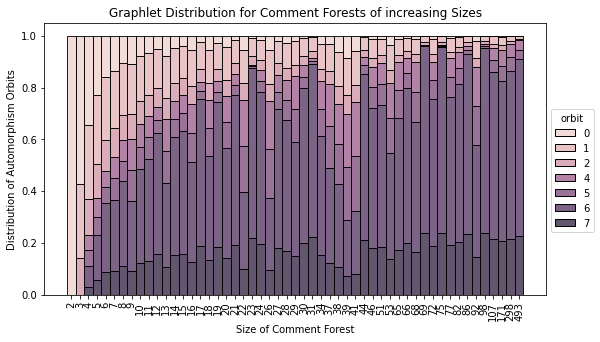

In [276]:
plt.figure(figsize=(9, 5))
g = sns.histplot(data=df, x="n_comments", weights="value", hue="orbit", multiple="stack", stat="count")
g.legend_.set_bbox_to_anchor((1.0, .7))
plt.xticks(rotation=90)
plt.xlabel("Size of Comment Forest")
plt.ylabel("Distribution of Automorphism Orbits")
plt.title("Graphlet Distribution for Comment Forests of increasing Sizes")
plt.savefig("graphlet_dist.pdf", bbox_inches="tight")
plt.show()

In [ ]:
# GDV Kernel zwischen den verschiedenen Bins

In [60]:
gdvs = []
for df in dataframes:
    gdv = df.sum(axis=0).to_numpy()[1:]
    gdv = np.divide(gdv, np.linalg.norm(gdv))
    gdvs.append(gdv)

In [262]:
# GDV-Kernel
sim = np.zeros((len(gdvs), len(gdvs)))

for i in range(len(gdvs)):
    for j in range(len(gdvs)):
        sim[i][j] = np.inner(gdvs[i], gdvs[j])

sim

array([[1.        , 0.74462241, 0.74462241, 0.62506075, 0.41288313],
       [0.74462241, 1.        , 1.        , 0.67283849, 0.48423735],
       [0.74462241, 1.        , 1.        , 0.67283849, 0.48423735],
       [0.62506075, 0.67283849, 0.67283849, 1.        , 0.9556176 ],
       [0.41288313, 0.48423735, 0.48423735, 0.9556176 , 1.        ]])

In [ ]:
# Weisfeiler-Lehmann Kernel

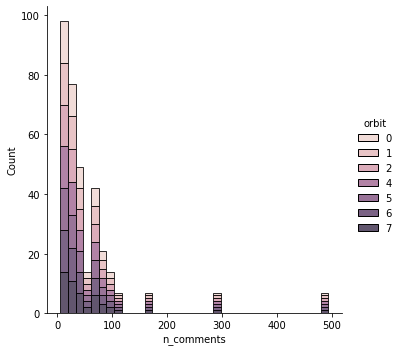

In [81]:
sns.displot(df, x="orbit", hue="orbit", multiple="stack")
#g.legend_.set_bbox_to_anchor((1.0, .7))
#plt.xlabel("Number of Comments [log 10]")
#plt.title("Distance of Subreddits in Network vs. Comments about Topic")
#plt.savefig("ego_distance_vs_comments_ukraine.pdf", bbox_inches="tight")

1


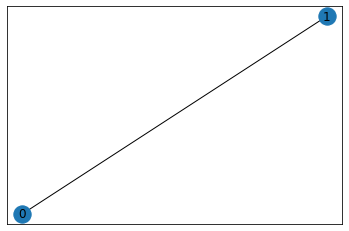

1


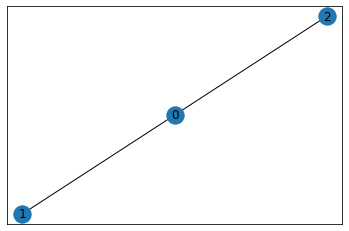

1


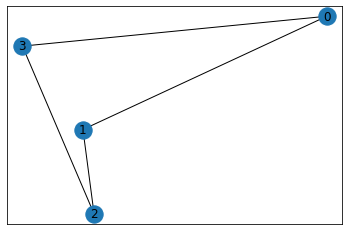

1


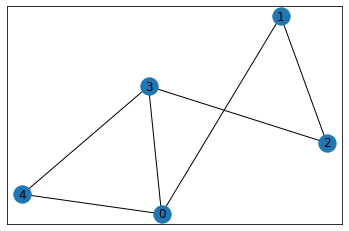

In [115]:
df = dataframes[0]
for cnt, automorphism in zip(df[df["id"] == 75].to_numpy()[0][1:], graphs):
    if cnt != 0:
        print(cnt)
        nx.draw_networkx(automorphism)
        plt.show()

In [94]:
from networkx.generators.atlas import *

G3


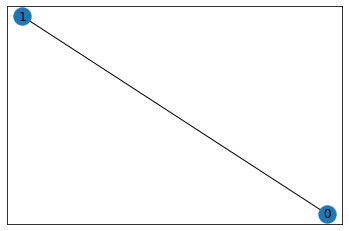

G6


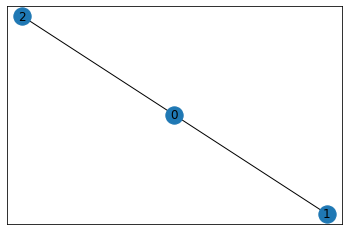

G7


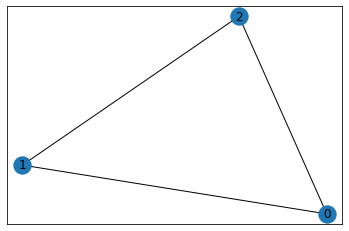

G13


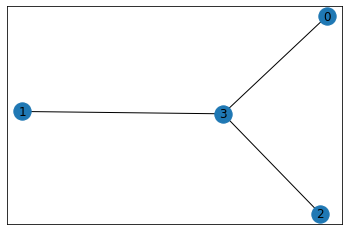

G14


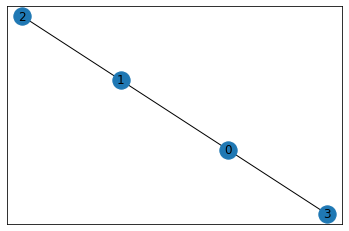

G15


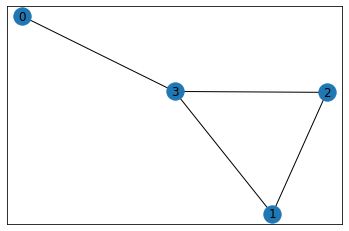

G16


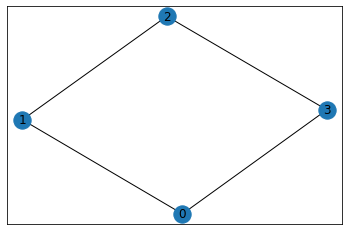

G17


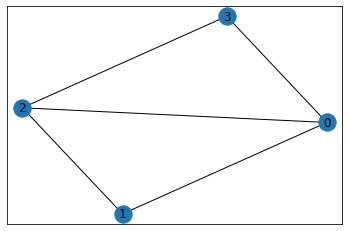

G18


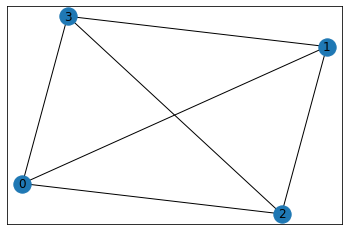

G29


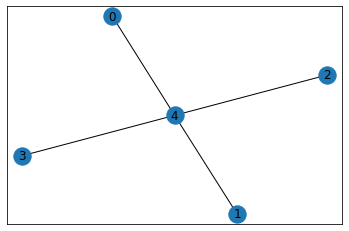

G30


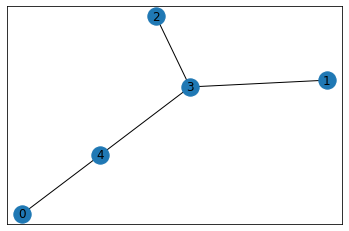

G31


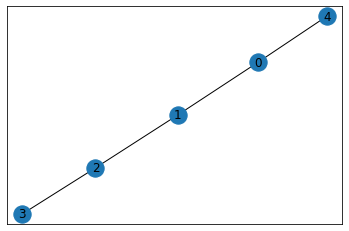

G34


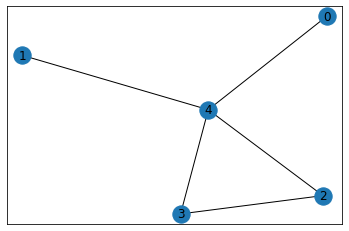

G35


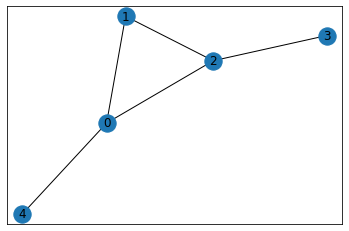

G36


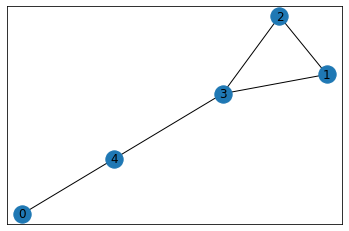

G37


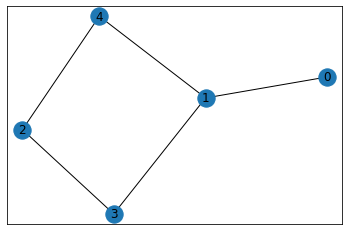

G38


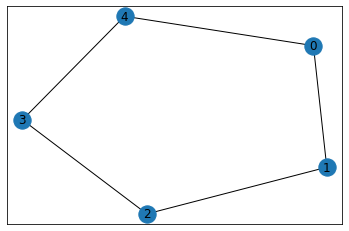

G40


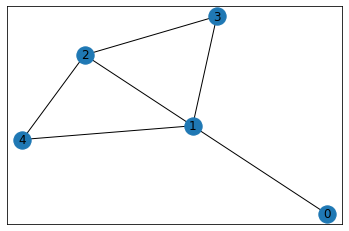

G41


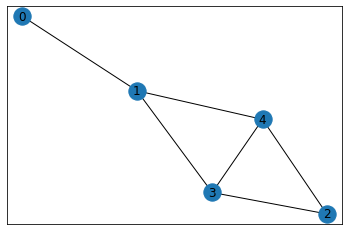

G42


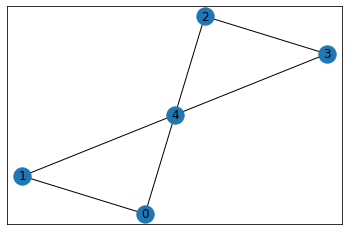

G43


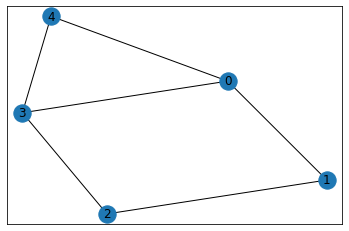

G44


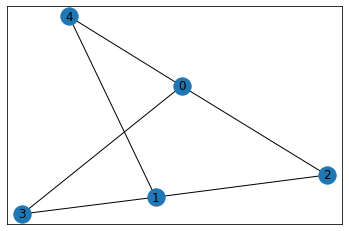

G45


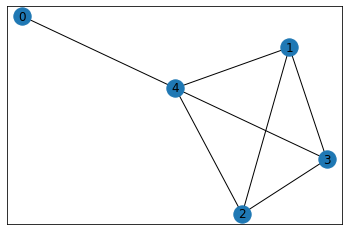

G46


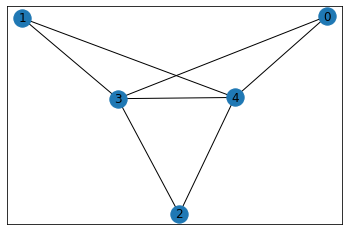

G47


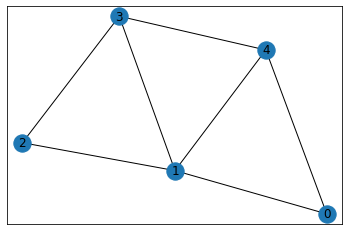

G48


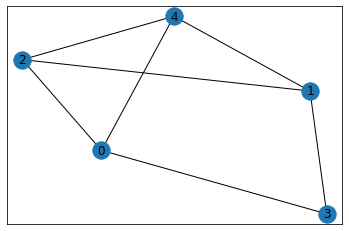

G49


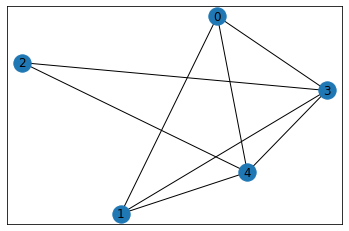

G50


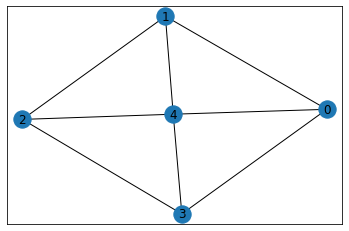

G51


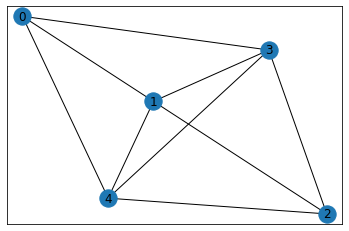

G52


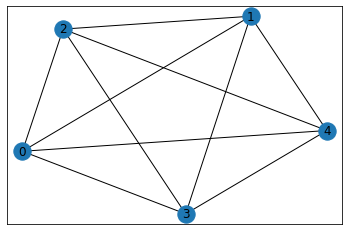

In [111]:
def enumerate_graphlets(N):
    graphs = []
    for graph in graph_atlas_g():
        if graph.number_of_nodes() > 1 and graph.number_of_nodes() < N + 1 and nx.is_connected(graph):
            print(graph)
            nx.draw_networkx(graph)
            plt.show()
            graphs.append(graph)
    return graphs

graphs = enumerate_graphlets(5)

In [116]:
def enumerate_graphs(graphlet_size):
    """
    Creating a hash table of the benchmark motifs.
    """
    graphs = graph_atlas_g()
    interesting_graphs = {i: [] for i in range(2, graphlet_size+1)}
    for graph in graphs:
        if graph.number_of_nodes() > 1 and graph.number_of_nodes() < graphlet_size+1:
            if nx.is_connected(graph):
                interesting_graphs[graph.number_of_nodes()].append(graph)
    return interesting_graphs

In [117]:
interesting_graphs = enumerate_graphs(5)

In [129]:
interesting_graphs.items()

dict_items([(2, [<networkx.classes.graph.Graph object at 0x7fdafbc57630>]), (3, [<networkx.classes.graph.Graph object at 0x7fdafbc57048>, <networkx.classes.graph.Graph object at 0x7fdafbc57080>]), (4, [<networkx.classes.graph.Graph object at 0x7fdafbcf48d0>, <networkx.classes.graph.Graph object at 0x7fdafbcf4198>, <networkx.classes.graph.Graph object at 0x7fdafbcf49b0>, <networkx.classes.graph.Graph object at 0x7fdafbcf47f0>, <networkx.classes.graph.Graph object at 0x7fdafbcf4eb8>, <networkx.classes.graph.Graph object at 0x7fdafbcf4080>]), (5, [<networkx.classes.graph.Graph object at 0x7fdafbcf45c0>, <networkx.classes.graph.Graph object at 0x7fdafbcf40b8>, <networkx.classes.graph.Graph object at 0x7fdafbcf47b8>, <networkx.classes.graph.Graph object at 0x7fdafbcf4320>, <networkx.classes.graph.Graph object at 0x7fdafbcf4438>, <networkx.classes.graph.Graph object at 0x7fdafbcf4358>, <networkx.classes.graph.Graph object at 0x7fd8efb4e128>, <networkx.classes.graph.Graph object at 0x7fd8efb4

In [123]:
unique_motif_count = 0
categories = None
def enumerate_categories():
    global unique_motif_count
    global categories
    global interesting_graphs
    """
    Creating a hash table of benchmark orbital roles.
    """
    main_index = 0
    categories = dict()
    for size, graphs in interesting_graphs.items():
        categories[size] = dict()
        for index, graph in enumerate(graphs):
            categories[size][index] = dict()
            degrees = list(set([graph.degree(node) for node in graph.nodes()]))
            for degree in degrees:
                categories[size][index][degree] = main_index
                main_index = main_index + 1
    unique_motif_count = main_index + 1

enumerate_categories()

In [125]:
categories

{2: {0: {1: 0}},
 3: {0: {1: 1, 2: 2}, 1: {2: 3}},
 4: {0: {1: 4, 3: 5},
  1: {1: 6, 2: 7},
  2: {1: 8, 2: 9, 3: 10},
  3: {2: 11},
  4: {2: 12, 3: 13},
  5: {3: 14}},
 5: {0: {1: 15, 4: 16},
  1: {1: 17, 2: 18, 3: 19},
  2: {1: 20, 2: 21},
  3: {1: 22, 2: 23, 4: 24},
  4: {1: 25, 2: 26, 3: 27},
  5: {1: 28, 2: 29, 3: 30},
  6: {1: 31, 2: 32, 3: 33},
  7: {2: 34},
  8: {1: 35, 2: 36, 3: 37, 4: 38},
  9: {1: 39, 2: 40, 3: 41},
  10: {2: 42, 4: 43},
  11: {2: 44, 3: 45},
  12: {2: 46, 3: 47},
  13: {1: 48, 3: 49, 4: 50},
  14: {2: 51, 4: 52},
  15: {2: 53, 3: 54, 4: 55},
  16: {2: 56, 3: 57},
  17: {2: 58, 3: 59, 4: 60},
  18: {3: 61, 4: 62},
  19: {3: 63, 4: 64},
  20: {4: 65}}}

In [74]:
for i, v in enumerate(dataframes[0].iloc[75].to_numpy()):
    if v != 0:
        print(i, v)


0 97
1 2
2 1
3 1
7 6
8 1
18 15
21 18
22 6


In [67]:
X = dataframes[0].to_numpy()
for i,v in enumerate(np.sum(X,axis=0)):
    if v != 0:
        print(i+1, v)

1 7381
2 242
3 786
4 393
6 3585
7 1195
8 1934
9 1934
17 14756
18 3689
19 25833
20 8611
21 8611
22 3072
23 4608


<h3>Temporal Interaction Graph of Users</h3>

In [159]:
# link author
# author

def create_interaction_graph(file_paths):
    G = nx.MultiDiGraph()
    comment2user = {}
    
    for file_path in tqdm(file_paths):
        with bz2.open(file_path, "rt") as file:
            for line in file:
                comment = json.loads(line)
                comment_id = comment.get("name")
                parent_id = comment.get("parent_id")
                submission_id = comment.get("link_id")
                #subreddit_id = comment.get("subreddit_id")
                #subreddit_name = comment.get("subreddit")
                author = comment.get("author")
                link_author = comment.get("link_author")
                link_title = comment.get("link_title")
                created_at = comment.get("created_utc")
                
                if not is_relevant_title(link_title):
                    continue
                    
                if parent_id == submission_id:  # top level comment
                    if submission_id not in comment2user:  #  es kann mehrere top level comments geben, also nur einmal inserten
                        comment2user[submission_id] = link_author
                        G.add_node(link_author, link_author=True)

                    comment2user[comment_id] = author
                    G.add_edge(author, link_author, created_at=created_at)
                elif parent_id in comment2user:  # only insert comment if we know the predecessor
                    comment2user[comment_id] = author
                    G.add_edge(author, comment2user[parent_id], created_at=created_at)
                    
    return G

In [343]:
files =  sorted([join(PATH + "comments/", f) for f in listdir(PATH + "comments/") 
          if isfile(join(PATH + "comments/", f))])

interaction_graph = create_interaction_graph(files[:100])

100%|██████████| 100/100 [15:36<00:00,  9.36s/it]


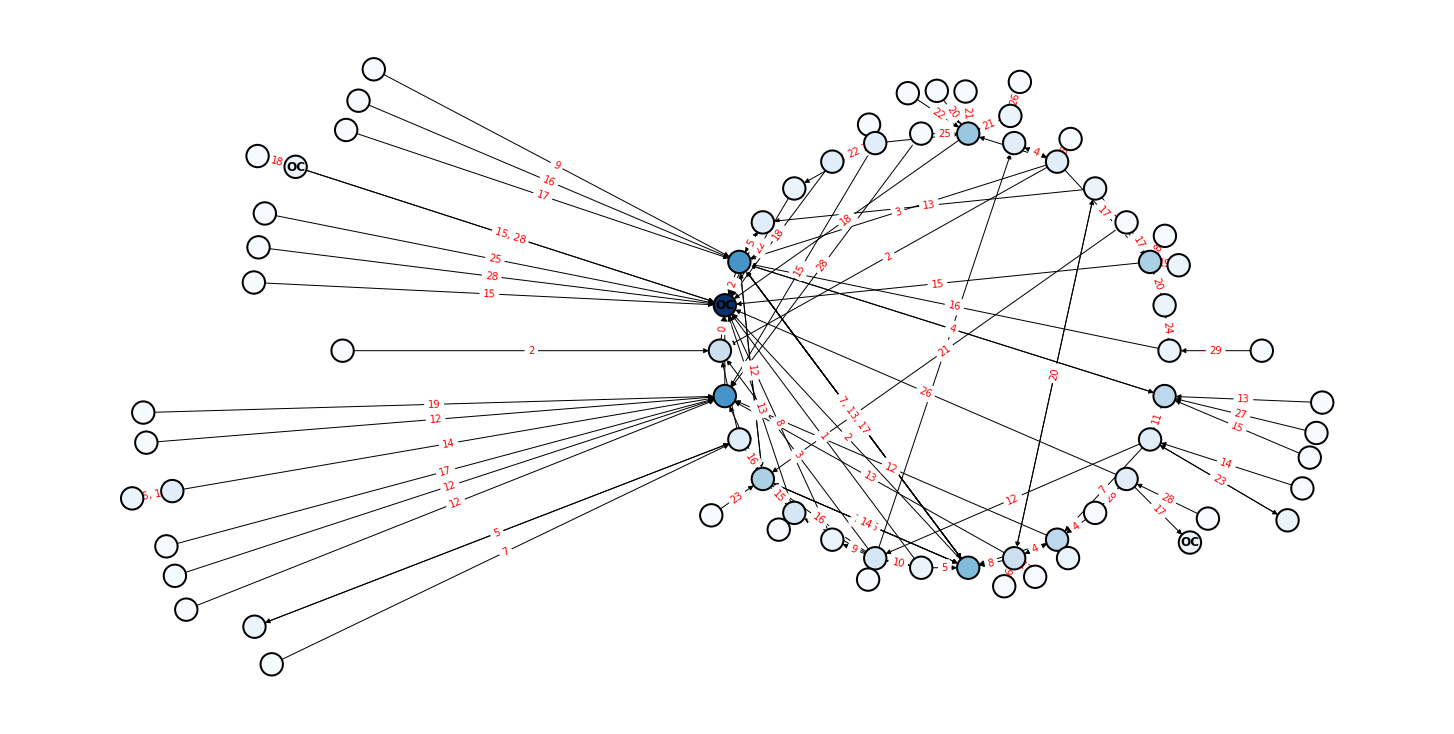

In [287]:
cnt = 1
for interaction_sub in nx.weakly_connected_components(interaction_graph):
    if len(interaction_sub) > 20:
        H = interaction_graph.subgraph(interaction_sub)

        # node colors
        node_degrees = [v for _,v in list(H.in_degree(H.nodes()))]   # list of in-degrees
        
        # node labels
        node_labels = {node: "OC" if "link_author" in H.nodes[node] else "" for node in H.nodes()}
        
        # edge labels: minutes since post creation (or right now as a work around: since first comment)
        edge_labels = {(u, v): [int(d["created_at"]) for d in H.get_edge_data(u, v).values()] for u, v in H.edges()}

        start = min(edge_labels.values(), key=lambda n: n[0])[0]
        step = 60
        edge_labels = {k: ", ".join([str(math.ceil((v-start) / step)) for v in vs]) for k,vs in edge_labels.items()}
        
        pos=graphviz_layout(H, prog='circo')
        
        plt.figure(figsize=(20, 10))
        nx.draw(H,
            pos,
            node_color=node_degrees,
            cmap=plt.cm.Blues,
            node_size=500, 
            with_labels=True, 
            linewidths=2,
            labels=node_labels,
            edgecolors="black",
            font_weight="bold")
            #width=alphas, 
            
           #edge_color=colors)
        
        nx.draw_networkx_edge_labels(H, pos,
            edge_labels=edge_labels,
            font_color='red'
        )
        #plt.savefig("interaction_graph_example.pdf")
        plt.show()
        cnt -= 1
        if cnt == 0:
            break

In [294]:
len(max(nx.weakly_connected_components(interaction_graph), key=lambda n: len(n)))

29903

<h3>Graphlets</h3>

In [344]:
H = interaction_graph.subgraph(max(nx.weakly_connected_components(interaction_graph), key=lambda n: len(n)))
str2int = {n: i for i, n in enumerate(H.nodes())}
H_numerical = nx.relabel_nodes(H, str2int, copy=True)

In [345]:
len(H_numerical.nodes())

29903

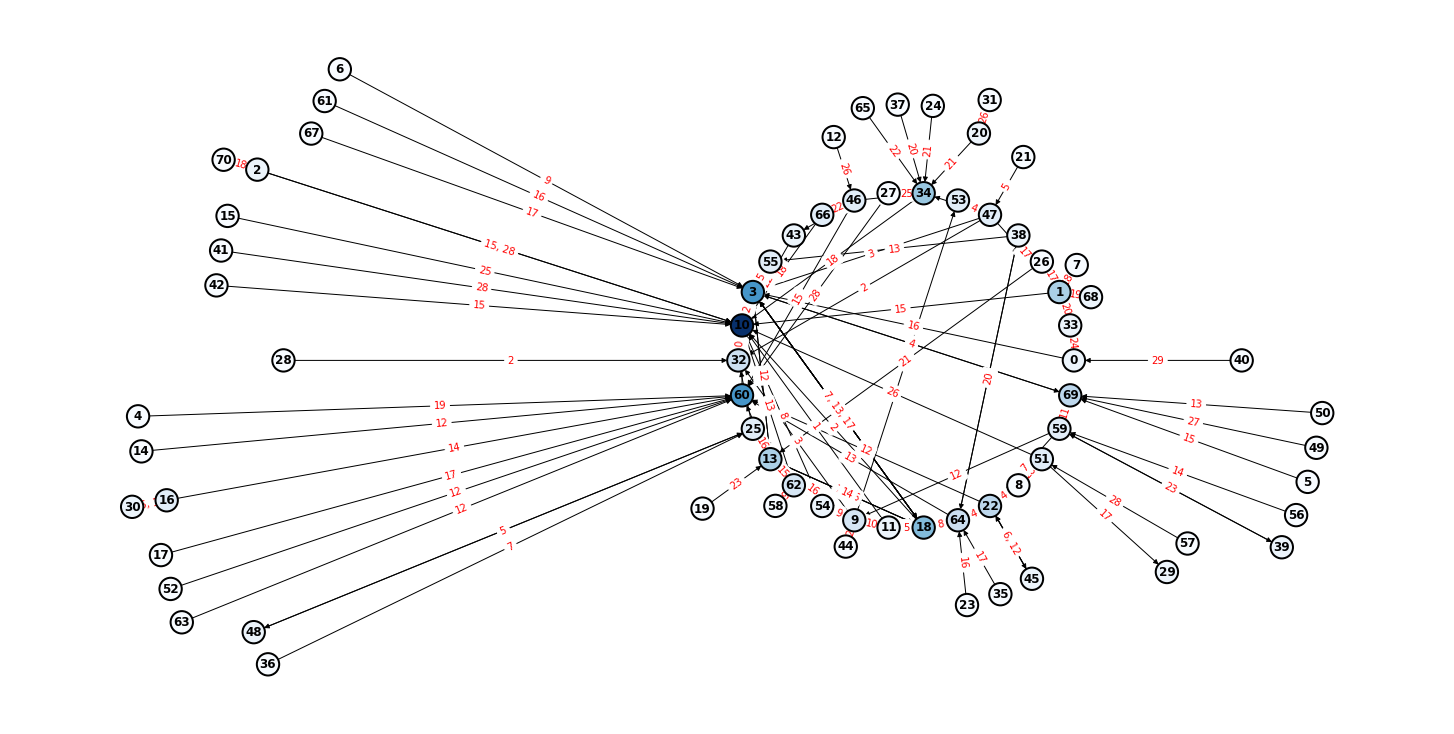

In [14]:
pos=graphviz_layout(H_numerical, prog='circo')
edge_labels = {(str2int[u], str2int[v]): x for (u,v),x in edge_labels.items()}

plt.figure(figsize=(20, 10))
nx.draw(H_numerical,
    pos,
    node_color=node_degrees,
    cmap=plt.cm.Blues,
    node_size=500, 
    with_labels=True, 
    linewidths=2,
    edgecolors="black",
    font_weight="bold")

nx.draw_networkx_edge_labels(H_numerical, pos,
    edge_labels=edge_labels,
    font_color='red'
)
plt.show()

61


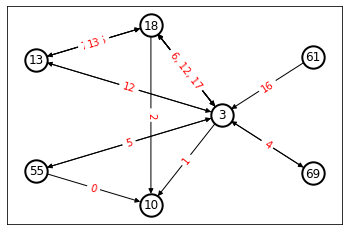

In [16]:
for n in H_numerical.nodes():
    if n != 61:
        continue
    
    ego = nx.ego_graph(H_numerical, n, 2)
    edge_labels = {(u, v): [int(d["created_at"]) for d in H_numerical.get_edge_data(u, v).values()] for u, v in ego.edges()}

    start = min(edge_labels.values(), key=lambda n: n[0])[0]
    step = 60
    edge_labels = {k: ", ".join([str(math.ceil((v-start) / step)) for v in vs]) for k,vs in edge_labels.items()}

    pos=graphviz_layout(ego, prog='circo')
    
    nx.draw_networkx(ego, pos, with_labels=True, node_color="white",linewidths=2,
    edgecolors="black", node_size=500)
    
    nx.draw_networkx_edge_labels(H_numerical, pos,
        edge_labels=edge_labels,
        font_color='red'
    )
    print(n)
    break

Persist Temporal Graph in order to Temporal Network Motifs

In [346]:
temp_edges = []
t_min = np.Inf
for u,v in H_numerical.edges():
    data = H_numerical.get_edge_data(u, v).values()
    for d in data:
        temp_edges.append((u, v, d["created_at"]))
        t_min = min(t_min, d["created_at"])
        

step = 60
temp_edges = [(u, v, math.ceil((t-t_min) / step)) for u,v,t in temp_edges]
with open("temporal_graph.csv", "w") as file:
    for u,v,t in temp_edges:
        file.write("{} {} {}\n".format(u, v, t))

<h3>Count Motifs</h3>

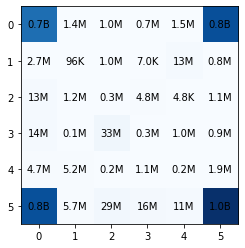

In [347]:
delta=30  # max 1h

os.system("/home/florian/snap/examples/temporalmotifs/temporalmotifsmain -i:temporal_graph.csv -o:temporal_motifs.csv -delta:{}".format(delta))

motif_cnt = np.genfromtxt("temporal_motifs.csv", delimiter=" ")
df = pd.DataFrame(motif_cnt)

def convert_label(n):
    exp = np.log10(n)
    postfix = "B" if exp > 8 else "M" if exp > 5 else "K" if exp > 2 else ""
    prefix_exp = 9 if exp > 8 else 6 if exp > 5 else 3 if exp > 2 else 0
    prefix = round(n/10**prefix_exp, 1)
    prefix = prefix if prefix < 10 else int(prefix)
    return "{}{}".format(prefix, postfix)

# plotting
fig, ax = plt.subplots()
plt.imshow(df, cmap=plt.cm.Blues)

# text
for i in range(len(df)):
    for j in range(len(df)):
        ax.text(i, j, convert_label(df[i][j]), ha="center", va="center")

plt.show()

<h3>Observe the time it takes for a motif to form</h3>

In [ ]:
motif_timeline = defaultdict(list)
delta = 1  # time for a motif to complete
t_max = max(temp_edges, key=lambda n: n[2])[2]
for i in tqdm(range(math.ceil(t_max/delta))):  # computes the bin with interval delta*i
    os.system("/home/florian/snap/examples/temporalmotifs/temporalmotifsmain -i:temporal_graph.csv -o:temporal_motifs.csv -delta:{}".format(i*delta))
    motif_cnt = np.genfromtxt("temporal_motifs.csv", delimiter=" ")
    df = pd.DataFrame(motif_cnt)
    for ii in range(df.shape[0]):
        for jj in range(df.shape[1]):
            motif_timeline[(ii,jj)].append(df.loc[ii,jj])

 98%|█████████▊| 2143/2190 [07:14<00:09,  5.15it/s]

In [ ]:
for (a,b), vals in motif_timeline.items():
    for i in range(len(vals))[::-1]:
        if i > 0:
            vals[i] -= vals[i-1]

In [ ]:
x = [i*delta for i in range(len(motif_timeline[(0,0)]))]
fig, ax = plt.subplots()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.plot(x, motif_timeline[(0,0)], linewidth=3, label="M1,1")
plt.plot(x, motif_timeline[(0,5)], linewidth=3, label="M1,6", linestyle="-.")
#plt.plot(x, motif_timeline[(5,0)],linewidth=3, label="M6,1", linestyle=":")
plt.plot(x, motif_timeline[(5,5)], linewidth=3, label="M6,6", linestyle="--")


#plt.plot(x, gaussian_filter1d(motif_timeline[(0,0)], sigma=3), linewidth=3, label="M1,1")
#plt.plot(x, gaussian_filter1d(motif_timeline[(0,5)], sigma=3),linewidth=3, label="M1,6", linestyle="-.")
#plt.plot(x, gaussian_filter1d(motif_timeline[(5,0)], sigma=2),linewidth=3, label="M6,1", linestyle=":")
#plt.plot(x, gaussian_filter1d(motif_timeline[(5,5)], sigma=2), linewidth=3, label="M6,6", linestyle="--")

    
plt.xlabel("Time to complete motif (minutes)")
plt.ylabel("Number of instances")
plt.title("Motif counts over time $(Bin size: \delta = {}min)$".format(delta))
plt.xscale("log")
#plt.yscale("log")
plt.legend()
plt.gca().set_xlim(left=10)
plt.gca().set_ylim(bottom=1)
plt.show()